# ETTm1에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기
* 이전과 다르게 sequence_length를 `4(15minutes*4)*24(24hours)*30(30days) = 2880` 즉 30일을 바라봄

In [2]:
hour_data = pd.read_csv('./GeneralData/ETTh1.csv')
hour_data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


* minute data를 hour data와 비교했을때 누적이아닌 단순히 분단위로 추적했을 뿐이다.

In [3]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [4]:
data = pd.read_csv('./GeneralData/ETTm2.csv')
sequence_length = 4*24*30 # 4*24*30 
pred_len = 1

## 2. Sequence중에 빈 시간이 없나 Check

In [5]:
import datetime as dt

In [6]:
data['date'] = pd.to_datetime(data['date'])
for i in range(data.shape[0]-1):
    if data['date'].iloc[i]+dt.timedelta(minutes = 15) == data['date'].iloc[i+1]: continue        
    else: print(i)

### &rightarrow; 빈시간 없음

In [7]:
data = data[['OT']]

In [8]:
data

,OT
0,38.661999
1,38.223000
2,37.344002
3,37.124001
4,37.124001
...,...
69675,45.986500
69676,45.986500
69677,45.546501
69678,45.546501


<AxesSubplot: >

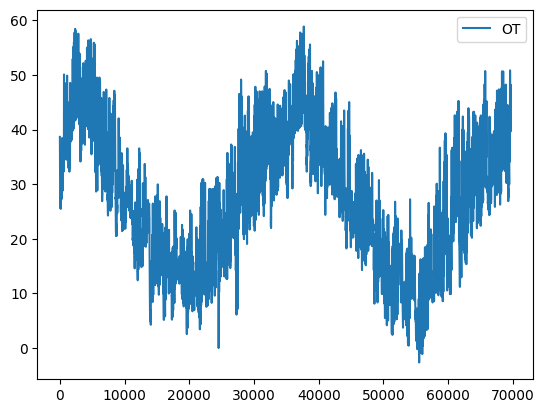

In [9]:
data.plot()

In [10]:
from torch import FloatTensor as FloatTensor

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [13]:
seed = 42

In [14]:
device = torch.device("cuda:0")

In [15]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 3. Train-Validation set으로 쪼개기

In [16]:
data

,OT
0,38.661999
1,38.223000
2,37.344002
3,37.124001
4,37.124001
...,...
69675,45.986500
69676,45.986500
69677,45.546501
69678,45.546501


* 69680개 중 일주일치 데이터인 672개의 데이터를 Test Set
* 69008개 중 0.2의 비율인 13802개는 validation set
* 69008개 중 0.8의 비율인 55206개는 train set

In [17]:
val_num = 13802

In [18]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_723477/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [19]:
next(iter(validation))[0].size()

torch.Size([64, 1, 2880])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [21]:
import copy

In [22]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 3872.310
changed
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 546.088
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 837.869
changed
Epoch [61]/[100] running accumulative loss across all batches: 2160.294
Epoch [81]/[100] running accumulative loss across all batches: 509.112


### validation set에 대해서 attribution 구하기

In [23]:
n = len(validation)
n

171

In [24]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [25]:
len(nt_ig_attr_score)

2880

<AxesSubplot: >

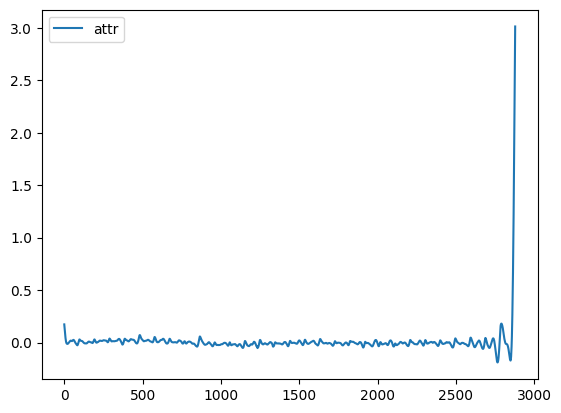

In [26]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,1.164341
1,1.043728
2,0.917571
3,0.792379
4,0.668862
...,...
2875,15.933270
2876,17.271362
2877,18.587374
2878,19.873351


#### train_index구하기

In [28]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [29]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


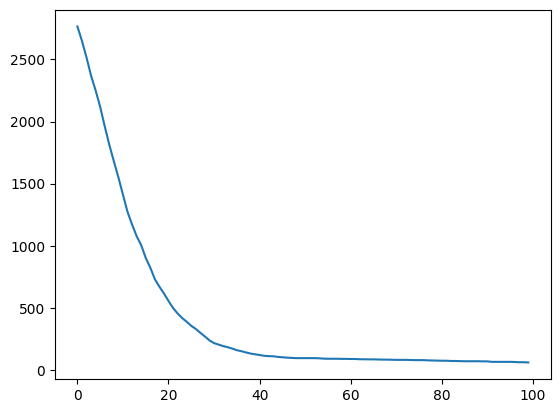

In [30]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [31]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[-0.8885, -0.8885, -0.8885,  ..., 14.7120, 14.7120, 14.7120]],

        [[-0.8885, -0.8885, -0.6690,  ..., 14.7120, 14.7120, 14.7120]],

        [[-0.8885, -0.6690, -0.2295,  ..., 14.7120, 14.7120, 14.9315]],

        ...,

        [[ 6.5820,  6.5820,  6.5820,  ..., 22.6220, 22.4020, 22.4020]],

        [[ 6.5820,  6.5820,  6.5820,  ..., 22.4020, 22.4020, 22.1825]],

        [[ 6.5820,  6.5820,  6.5820,  ..., 22.4020, 22.1825, 22.1825]]],
       device='cuda:0') tensor([[[14.7120]],

        [[14.9315]],

        [[14.9315]],

        [[14.9315]],

        [[14.9315]],

        [[14.9315]],

        [[15.1515]],

        [[15.3715]],

        [[15.8105]],

        [[16.0300]],

        [[16.2500]],

        [[16.6895]],

        [[17.1285]],

        [[17.7880]],

        [[18.4475]],

        [[19.1065]],

        [[19.9855]],

        [[20.8645]],

        [[22.1825]],

        [[23.0615]],

        [[23.7210]],

        [[24.6000]],

        [[25.0390]],

        [[25.4785]

tensor([[[ 9.6585,  9.6585,  9.6585,  ..., 27.6755, 27.4560, 27.0165]],

        [[ 9.6585,  9.6585,  9.6585,  ..., 27.4560, 27.0165, 27.0165]],

        [[ 9.6585,  9.6585,  9.4385,  ..., 27.0165, 27.0165, 26.7970]],

        ...,

        [[ 9.4385,  9.4385,  9.4385,  ..., 14.4920, 14.4920, 14.2725]],

        [[ 9.4385,  9.4385,  9.4385,  ..., 14.4920, 14.2725, 14.2725]],

        [[ 9.4385,  9.4385,  9.4385,  ..., 14.2725, 14.2725, 14.2725]]],
       device='cuda:0') tensor([[[27.0165]],

        [[26.7970]],

        [[26.3570]],

        [[26.1375]],

        [[25.9180]],

        [[25.4790]],

        [[25.0390]],

        [[24.8195]],

        [[24.3800]],

        [[24.1600]],

        [[23.9405]],

        [[23.7210]],

        [[23.2810]],

        [[22.8420]],

        [[22.4020]],

        [[21.9630]],

        [[21.7430]],

        [[21.5230]],

        [[21.0840]],

        [[20.6450]],

        [[20.6450]],

        [[20.2050]],

        [[20.2050]],

        [[19.7660]

tensor([[[22.6220, 22.4020, 22.4020,  ..., 31.3865, 31.1670, 30.9475]],

        [[22.4020, 22.4020, 22.1825,  ..., 31.1670, 30.9475, 30.9475]],

        [[22.4020, 22.1825, 22.1825,  ..., 30.9475, 30.9475, 30.9475]],

        ...,

        [[37.3440, 38.0030, 38.0030,  ..., 39.9560, 39.5165, 39.5165]],

        [[38.0030, 38.0030, 37.7835,  ..., 39.5165, 39.5165, 39.5165]],

        [[38.0030, 37.7835, 37.1240,  ..., 39.5165, 39.5165, 39.2970]]],
       device='cuda:0') tensor([[[30.9475]],

        [[30.9475]],

        [[30.7275]],

        [[30.5075]],

        [[30.5075]],

        [[30.5075]],

        [[30.5075]],

        [[30.5075]],

        [[30.2880]],

        [[30.0685]],

        [[30.0685]],

        [[29.8485]],

        [[29.6290]],

        [[29.4095]],

        [[28.9695]],

        [[28.9695]],

        [[28.7500]],

        [[28.5305]],

        [[28.3105]],

        [[28.3105]],

        [[28.0905]],

        [[27.8710]],

        [[27.6515]],

        [[27.6515]

tensor([[[26.1375, 26.1375, 26.1375,  ..., 29.6290, 29.8485, 29.8485]],

        [[26.1375, 26.1375, 26.1375,  ..., 29.8485, 29.8485, 30.2880]],

        [[26.1375, 26.1375, 26.1375,  ..., 29.8485, 30.2880, 30.7275]],

        ...,

        [[26.1375, 26.1375, 26.1375,  ..., 35.5615, 35.5615, 35.1220]],

        [[26.1375, 26.1375, 26.1375,  ..., 35.5615, 35.1220, 35.1220]],

        [[26.1375, 26.1375, 26.1375,  ..., 35.1220, 35.1220, 34.9025]]],
       device='cuda:0') tensor([[[30.2880]],

        [[30.7275]],

        [[31.1670]],

        [[31.8260]],

        [[32.2655]],

        [[32.4855]],

        [[32.9245]],

        [[33.5840]],

        [[34.0235]],

        [[34.6825]],

        [[35.1220]],

        [[35.5615]],

        [[36.4405]],

        [[37.3195]],

        [[37.7585]],

        [[38.1985]],

        [[38.8575]],

        [[39.2970]],

        [[39.7360]],

        [[40.1760]],

        [[40.6150]],

        [[41.2745]],

        [[41.4940]],

        [[41.9335]

tensor([[[43.4720, 42.8125, 42.3730,  ..., 31.1425, 31.1425, 31.1425]],

        [[42.8125, 42.3730, 41.9335,  ..., 31.1425, 31.1425, 31.1425]],

        [[42.3730, 41.9335, 41.4940,  ..., 31.1425, 31.1425, 31.1425]],

        ...,

        [[27.2120, 27.2120, 27.6515,  ..., 28.5060, 28.5060, 28.5060]],

        [[27.2120, 27.6515, 28.0905,  ..., 28.5060, 28.5060, 28.5060]],

        [[27.6515, 28.0905, 28.7500,  ..., 28.5060, 28.5060, 28.5060]]],
       device='cuda:0') tensor([[[31.1425]],

        [[31.1425]],

        [[31.1425]],

        [[31.1425]],

        [[31.1425]],

        [[31.1425]],

        [[31.1425]],

        [[31.1425]],

        [[31.1425]],

        [[30.9225]],

        [[30.7030]],

        [[30.7030]],

        [[30.4835]],

        [[30.2635]],

        [[30.2635]],

        [[30.2635]],

        [[30.2635]],

        [[30.2635]],

        [[30.0435]],

        [[29.8240]],

        [[29.8240]],

        [[29.8240]],

        [[29.8240]],

        [[29.8240]

tensor([[[27.6515, 27.6515, 27.2120,  ..., 39.4430, 39.4430, 39.2235]],

        [[27.6515, 27.2120, 26.9925,  ..., 39.4430, 39.2235, 39.0040]],

        [[27.2120, 26.9925, 26.7725,  ..., 39.2235, 39.0040, 39.0040]],

        ...,

        [[42.5930, 42.3730, 41.9335,  ..., 42.7390, 43.3985, 43.6180]],

        [[42.3730, 41.9335, 41.4940,  ..., 43.3985, 43.6180, 44.2770]],

        [[41.9335, 41.4940, 40.6155,  ..., 43.6180, 44.2770, 44.7170]]],
       device='cuda:0') tensor([[[39.0040]],

        [[39.0040]],

        [[38.7840]],

        [[38.5640]],

        [[38.3445]],

        [[38.1250]],

        [[37.9055]],

        [[37.6860]],

        [[37.6860]],

        [[37.2460]],

        [[37.2460]],

        [[37.2460]],

        [[36.8070]],

        [[36.8070]],

        [[36.8070]],

        [[36.8070]],

        [[36.8070]],

        [[36.3670]],

        [[36.3670]],

        [[36.1475]],

        [[35.9280]],

        [[35.7080]],

        [[35.4880]],

        [[35.4880]

In [32]:
val_x

tensor([[[33.7790, 33.5595, 33.3400,  ..., 38.5400, 38.3205, 38.3205]],

        [[33.5595, 33.3400, 33.1200,  ..., 38.3205, 38.3205, 38.3205]],

        [[33.3400, 33.1200, 33.1200,  ..., 38.3205, 38.3205, 38.5400]],

        ...,

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.9675,  ..., 35.4640, 35.4640, 35.4640]]],
       device='cuda:0')

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:1329.0064641993863
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:511.20382268207265
changed
changed
changed
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:753.2684569353053
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:780.583879484211
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:664.456344769307
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:1131.058941285417
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:806.8365029548689
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
22번째 모델 Training 완료 마지막 Epoch loss:40.86008206005355
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
32번째 모델 Training 완료 마지막 Epoch loss:22.763307671091965
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
41번째 모델 Training 완료 마지막 Epoch loss:20.04526045870207
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
42번째 모델 Training 완료 마지막 Epoch loss:20.468365011869796
changed
changed
changed
changed
changed
changed
changed
chang

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
51번째 모델 Training 완료 마지막 Epoch loss:19.241585933488338
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
61번째 모델 Training 완료 마지막 Epoch loss:18.962071079492443
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
70번째 모델 Training 완료 마지막 Epoch loss:18.78665881000288
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
80번째 모델 Training 완료 마지막 Epoch loss:18.542108684158084
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

In [42]:
val_y # 다음 예측 타겟값

tensor([[[38.3205]],

        [[38.5400]],

        [[38.5400]],

        [[38.7600]],

        [[38.9795]],

        [[38.9795]],

        [[38.7595]],

        [[38.5400]],

        [[38.5400]],

        [[38.1010]],

        [[38.1010]],

        [[38.1010]],

        [[38.1010]],

        [[37.6610]],

        [[37.6610]],

        [[37.2220]],

        [[37.2220]],

        [[36.7820]],

        [[36.7820]],

        [[36.7820]],

        [[36.7820]],

        [[36.3430]],

        [[36.3430]],

        [[36.1230]],

        [[35.9030]],

        [[35.9030]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.0240]]], device='cuda:0')

In [43]:
val_x # 예측 하는 값

tensor([[[33.7790, 33.5595, 33.3400,  ..., 38.5400, 38.3205, 38.3205]],

        [[33.5595, 33.3400, 33.1200,  ..., 38.3205, 38.3205, 38.3205]],

        [[33.3400, 33.1200, 33.1200,  ..., 38.3205, 38.3205, 38.5400]],

        ...,

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.9675,  ..., 35.4640, 35.4640, 35.4640]]],
       device='cuda:0')

In [44]:
val_x.size()

torch.Size([41, 1, 2880])

         out
99  0.209796


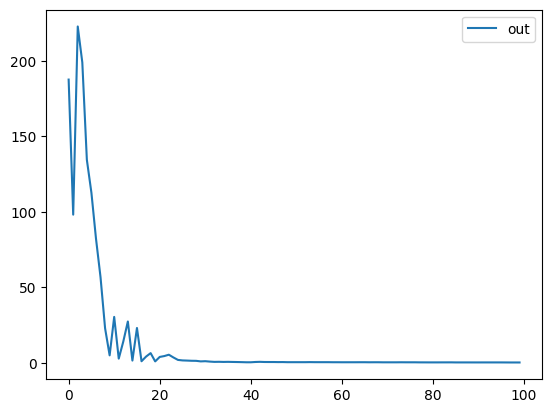

In [45]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
99  0.346228


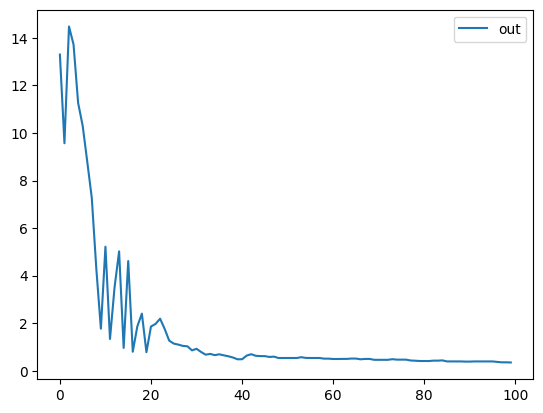

In [46]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
99  1.238246


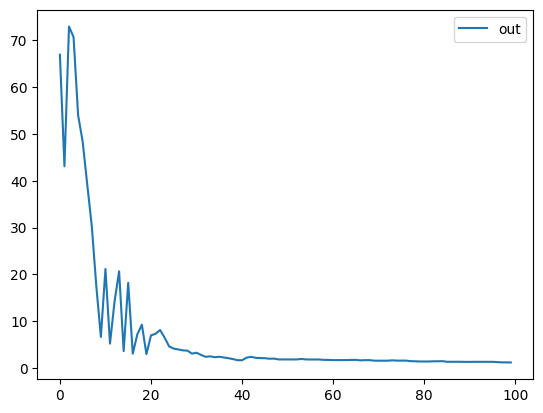

In [49]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

         out
99  0.458035


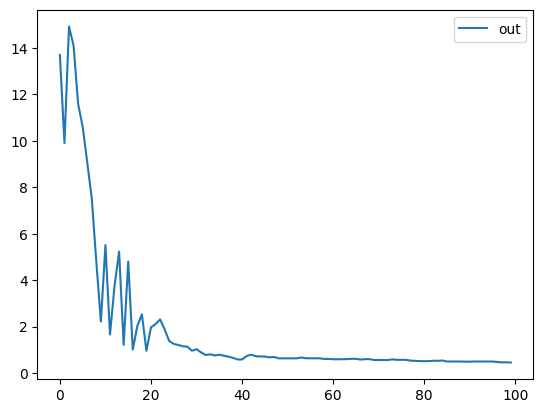

In [47]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [48]:
attr_df.describe()

,attr
count,2.880000e+03
mean,-1.973730e-17
std,1.000174e+00
min,-1.380583e+00
25%,-1.578949e-01
50%,-7.155732e-02
75%,3.173574e-02
max,2.107269e+01
